In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import glob
from collections import Counter
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

from scipy.stats import linregress
from skimage.transform import rescale, resize

from PIL import ImageDraw
from matplotlib.colors import ListedColormap

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
BASEDIR = Path("/content/drive/MyDrive/silicanets-data/")

### Load a trained model

In [ ]:
model_name = "resnet-strain-variable-2022-02-22T18_24_14"

#df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df.p")
#df_subsampled = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_subsampled.p")
#df_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_train.p")
#df_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_validation.p")
df_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_test.p")


#X_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_train.p")
#X_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_validation.p")
X_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_test.p")

#y_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_train.p")
#y_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_validation.p")
y_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_test.p")

#history_df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df.p")

# recover important settings
info = dict(pd.read_csv(BASEDIR / "output" / model_name / "model_info.csv").values)
dropout = float(info["dropout"])
try:
  training_data_disorder_variance = float(info["disorder_variance"])
except:
  training_data_disorder_variance = str(info["disorder_variance"])

In [ ]:
premaid = tf.keras.applications.ResNet50(
      include_top = False,
      pooling = "avg",
      weights = None,
      #input_shape=X_train[0].shape,
      input_shape = (128,128,1),
  )


inputs = tf.keras.Input(shape=(128, 128, 1))

resnet = premaid(inputs)
dropout = tf.keras.layers.Dropout(0,name = 'Drop')(resnet) #attenzione che forse è 0 per il nostro modello
outputs = tf.keras.layers.Dense(1,name = 'Output')(dropout)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [ ]:
model.load_weights(BASEDIR / "output" / model_name / "checkpoints")

In [ ]:
premaid.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

### Grad-CAM implementation


In order to implement Grad-CAM we have followed and customized the keras tutorial at: https://keras.io/examples/vision/grad_cam/

In [ ]:
def get_gc_heatmap(model,img_vect):
      
    last_conv_layer = model.get_layer('resnet50').get_layer('conv5_block3_out')
    last_conv_layer_model = tf.keras.Model(model.get_layer('resnet50').inputs, last_conv_layer.output)
    
    classifier_input = tf.keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input
    x = model.get_layer('resnet50').get_layer('avg_pool')(x) 
    x = model.get_layer('Drop')(x)
    x = model.get_layer('Output')(x)
    classifier_model = tf.keras.Model(classifier_input, x)
    
    with tf.GradientTape() as tape:
    
        last_conv_layer_output = last_conv_layer_model(img_vect)
        tape.watch(last_conv_layer_output)
   
        preds = classifier_model(last_conv_layer_output)
    
    grads = tape.gradient(preds, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    pooled_grads = pooled_grads.numpy()
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(last_conv_layer_output, axis = -1)

    return np.abs(heatmap)
    

Take into account the data-augmentation. For each original configuration (or run) we have applied data-augmentation (h_flip, v_flip, translations) generating 64 different copies for each configuration(or run). So we have decided to average out the Grad-CAM heatmap over the data-augmentation copies. Before the application of the average operation we have applied an inverse data-augmentation in order to make all the augmented samples live in the same sdr.

At first we define a function which returns all the Grad-CAM heatmap (already transformed to a common sdr) for a defined run:

In [ ]:
def get_gc_run_ensamble(run_name,model,df_X,X, 
                     h_f = False, v_f = False, rt_x = 0, rt_y = 0):
    
    run_im = df_X['run'].to_numpy()
    idx_run = []
    
    for i in range(len(run_im)):
    
        if run_im[i] == run_name:
            idx_run.append(i)
    
    horizontal_flip = df_X['horizontal_flip'].to_numpy()
    vertical_flip = df_X['vertical_flip'].to_numpy()
    
    relative_translation_x = df_X['relative_translation_x'].to_numpy()
    relative_translation_y = df_X['relative_translation_y'].to_numpy()
    
    

    heatmaps = []
    
    for i in idx_run:
        
        img_vect = X[i].reshape(1,128,128,1)
        img_vect = np.float32(img_vect)

        #compute Grad-CAM
        heatmap = get_gc_heatmap(model,img_vect)
        
        #resize the heatmap to 128x128
        heatmap = resize(heatmap, (128, 128),order = 0)

        #undo the data-augmentation
        if  vertical_flip[i]:
            
            heatmap = np.flipud(heatmap)
            
        if  horizontal_flip[i]:
            
            heatmap = np.fliplr(heatmap)
        
        heatmap_array = heatmap
        
        heatmap_array = np.roll(heatmap_array,-int(np.round((relative_translation_x[i])*128)),axis=1)#traslo su x
        heatmap_array = np.roll(heatmap_array,int(np.round((relative_translation_y[i])*128)),axis=0)#traslo su y
        
        #Trasnform the Grad-CAM heatmap in the desired sdr
        heatmap_array = np.roll(heatmap_array,int(np.round((rt_x)*128)),axis=1)#traslo su x
        heatmap_array = np.roll(heatmap_array,-int(np.round((rt_y)*128)),axis=0)#traslo su 
        
        if  v_f:
            
            heatmap_array = np.flipud(heatmap_array)
            
        if  h_f:
            
            heatmap_array = np.fliplr(heatmap_array)
        
        heatmaps.append(heatmap_array)
       
    heatmaps_arr = np.array(heatmaps)
    
    return heatmaps_arr

### Test the Grad-CAM

As an example we are going to test our function on a run in the test set:

In [ ]:
ens_gc = get_gc_run_ensamble(run_name='run_00760',model = model,df_X = df_test,X = X_test)

In [ ]:
print(np.mean(ens_gc, axis = 0).shape)

(128, 128)


### Plot the Grad-CAM heatmap on a silica configuration

We want to plot the Grad-CAM heatmap superimposed on a silica configuration. For simplicity, we choose the first image of the data-augmentation sample as ground (as first image we mean the first image in the df_test).

In [ ]:
#Select a run ensamble
run_name='run_00655'

#Define the first image of the ensamble as 'array_lattice'
run_im = df_test['run'].to_numpy()
idx = []
    
for i in range(len(run_im)):
    
    if run_im[i] == run_name:
        idx.append(i)
        
array_lattice = X_test[idx[0]]

#Define the parameter which define the sdr for the data-augmentation ensable
h_f = df_test['horizontal_flip'].to_numpy()[idx[0]]
v_f = df_test['vertical_flip'].to_numpy()[idx[0]]
    
rt_x = df_test['relative_translation_x'].to_numpy()[idx[0]]
rt_y = df_test['relative_translation_y'].to_numpy()[idx[0]]

#Compute the mean Grad-CAM heatmap 
mean_gc_heatmap = np.mean(get_gc_run_ensamble(run_name,model,df_test,X_test,
                                      h_f,v_f,rt_x,rt_y),axis = 0)


#Save the first bond break location to add it to the plot (just for more information)
relative_break_location_x = df_test['relative_break_location_x'].to_numpy()
relative_break_location_y = df_test['relative_break_location_y'].to_numpy()

x_rel_bb=relative_break_location_x[idx[0]]
y_rel_bb=relative_break_location_y[idx[0]]

#Preprocess the silica configuration image adding to it a white square in the bond break location

img_lattice = tf.keras.preprocessing.image.array_to_img(array_lattice)
    
draw = ImageDraw.Draw(img_lattice)
draw.rectangle([(x_rel_bb*128-2,(1-y_rel_bb)*128+2),(x_rel_bb*128+2,(1-y_rel_bb)*128-2)], fill=(255))
    
array_lattice_bb = tf.keras.preprocessing.image.img_to_array(img_lattice)

In [ ]:
def make_transparent_cmap(cmap, alpha_min=0, alpha_max=1):

    
    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:,-1] = np.linspace(alpha_min, alpha_max, cmap.N)
    

    # Create new colormap
    my_cmap = ListedColormap(my_cmap)
    
    return my_cmap

[]

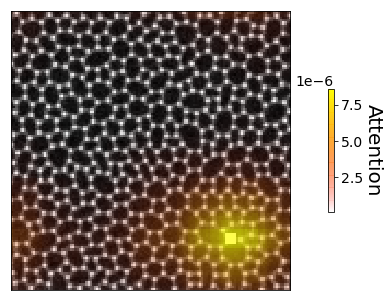

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set(aspect=1)
ax.matshow(array_lattice_bb[:, :, 0], cmap="Greys_r")
c = ax.matshow(mean_gc_heatmap.reshape((128,128,1))[:, :, 0], cmap=make_transparent_cmap(plt.cm.autumn, alpha_max=0.7))
cbar = fig.colorbar(c, shrink = 0.3, pad=0.1)
#cbar.ax.set_ylabel('Attention', rotation=270)
cbar.set_label('Attention', labelpad=20, rotation=270, size=20)
plt.tight_layout()
ax.set_xticks([])
ax.set_yticks([])